In [1]:
import pandas as pd
import numpy as np
import umap
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

2023-01-17 10:19:05.055390: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-17 10:19:05.055456: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Importing data

In [2]:
features_num = [
    'Total_flux', 'Peak_flux', 
       'NUV_flux_corr', 'u_flux_corr', 'Bw_flux_corr', 'R_flux_corr',
       'I_flux_corr', 'z_flux_corr', 'y_flux_corr',
       'J_flux_corr', 'H_flux_corr', 'K_flux_corr', 'Ks_flux_corr',
       'ch1_flux_corr', 'ch2_flux_corr', 'ch3_flux_corr', 'ch4_flux_corr',
       'F_MIPS_24', 'F_PACS_100', 'F_PACS_160', 'F_SPIRE_250', 'F_SPIRE_350',
       'F_SPIRE_500', 'Z_BEST',
       'g_flux_corr', 'nb921_hsc_flux_corr'
    ]
y_column = "Classification"

classes = ['jet-mode radio AGN/low-excitation radio galaxy', 'quasar-like radio AGN / high-excitation radio galaxy', 
           'radio-quiet AGN', 'star-forming galaxy']

### Original

In [3]:
data = pd.read_csv("../../Data/Fangyou_data/Cleaned/combined_using_similar_columns.csv")


X_original = data[features_num]

y_original = data[[y_column]]
y_original['Source'] = 'Original'

/var/lib/condor/execute/dir_348705/ipykernel_348769/2024827563.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_original['Source'] = 'Original'


In [4]:
# Temporary fix to weird blob
y_original = y_original[X_original['F_PACS_100']<1e5]
X_original = X_original[X_original['F_PACS_100']<1e5]

X_original = X_original.drop(columns=['Bw_flux_corr'])

In [5]:
X_original.isna().sum()/len(X_original)

Total_flux             0.000000
Peak_flux              0.000000
NUV_flux_corr          0.247426
u_flux_corr            0.097438
R_flux_corr            0.026782
I_flux_corr            0.058607
z_flux_corr            0.038514
y_flux_corr            0.422735
J_flux_corr            0.132133
H_flux_corr            0.785822
K_flux_corr            0.179601
Ks_flux_corr           0.786335
ch1_flux_corr          0.007150
ch2_flux_corr          0.000474
ch3_flux_corr          0.021305
ch4_flux_corr          0.017697
F_MIPS_24              0.041595
F_PACS_100             0.000000
F_PACS_160             0.000000
F_SPIRE_250            0.044913
F_SPIRE_350            0.044913
F_SPIRE_500            0.044913
Z_BEST                 0.000000
g_flux_corr            0.251731
nb921_hsc_flux_corr    0.633516
dtype: float64

### BH

In [6]:
data = pd.read_csv("../../Data/Best&Heckman/BestHeckman+SDSS+wise+LOFAR_better.csv")

# Only selecting data with a classification
data = data[data['Classification'] != 'Radio-loud AGN'] 

In [7]:
X_BH = data.drop(columns=['Classification', 'RAJ2000', 'DEJ2000', 'SimbadName', 'E_Total_flux', 'E_Peak_flux', 'wise_ra',
       'wise_dec', 'tmass_key'])


y_BH = data[['Classification']]
y_BH['Source'] = 'BH'

/var/lib/condor/execute/dir_348705/ipykernel_348769/1745830472.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_BH['Source'] = 'BH'


In [8]:
X_BH.isna().sum()/len(X_BH)

Z_BEST           0.000000
u_flux_corr      0.003495
g_flux_corr      0.003495
R_flux_corr      0.003495
I_flux_corr      0.003495
z_flux_corr      0.003495
ch1_flux_corr    0.000076
ch2_flux_corr    0.000076
J_flux_corr      0.078256
H_flux_corr      0.078256
Ks_flux_corr     0.078256
Total_flux       0.615332
Peak_flux        0.615332
dtype: float64

### MIGHTEE

In [9]:
data = pd.read_csv("../../Data/MIGHTEE/Classification/final_gaussian_radio_more.csv")

In [10]:
# Dropping nan classifications
data = data[data['Classification'].notna()]

# Dropping quasar-like radio AGN / high-excitation radio galaxy
#mightee_data = mightee_data[mightee_data['Classification'] != 'star-forming galaxy']
print("Amount of rows:", len(data))

Amount of rows: 4370


In [11]:
X_MIGHTEE = data.drop(columns=['Classification', 'XAGN', 'midIRAGN', 'VLBAAGN', 
                               'RLAGN', 'optAGN', 'Unnamed: 0', 'S_INT14', 
                               'S_PEAK14', 'EBV'])

y_MIGHTEE = data[['Classification', 'XAGN', 'midIRAGN', 'VLBAAGN', 'RLAGN', 'optAGN']]
y_MIGHTEE['Source'] = 'MIGHTEE'

/var/lib/condor/execute/dir_348705/ipykernel_348769/313757976.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_MIGHTEE['Source'] = 'MIGHTEE'


In [12]:
# Replacing columns by similar columns
X_MIGHTEE[['I_flux_corr', 'R_flux_corr']] = X_MIGHTEE[['i_flux_corr', 'r_flux_corr']]
X_MIGHTEE = X_MIGHTEE.drop(columns=['i_flux_corr', 'r_flux_corr'])

In [13]:
# Dropping columns with a lot of missing values, not however that if they appear in the other tables we do not drop them

In [14]:
X_MIGHTEE = X_MIGHTEE.drop(columns=['NUV_flux_corr', 'FUV_flux_corr'])

In [15]:
X_MIGHTEE.isna().sum()/len(X_MIGHTEE)

Z_BEST           0.000000
ch1_flux_corr    0.013043
ch2_flux_corr    0.014874
ch3_flux_corr    0.028146
ch4_flux_corr    0.015103
F_MIPS_24        0.000000
F_PACS_100       0.000000
F_PACS_160       0.100000
F_SPIRE_250      0.256064
F_SPIRE_350      0.368192
F_SPIRE_500      0.709382
Ks_flux_corr     0.019680
H_flux_corr      0.013501
J_flux_corr      0.010755
u_flux_corr      0.036156
z_flux_corr      0.001373
y_flux_corr      0.019222
Total_flux       0.000000
Peak_flux        0.021510
I_flux_corr      0.002288
R_flux_corr      0.003661
dtype: float64

## Combining

In [73]:
X = pd.concat([X_original, X_BH, X_MIGHTEE]).reset_index(drop=True)
y = pd.concat([y_original, y_BH, y_MIGHTEE]).reset_index(drop=True)

In [74]:
# Temp, since these aren't shared in all
X = X.drop(columns=['y_flux_corr', 'Total_flux', 'Peak_flux', 'ch3_flux_corr', 'ch4_flux_corr',
       'F_MIPS_24', 'F_PACS_100', 'F_PACS_160', 'F_SPIRE_250', 'F_SPIRE_350',
       'F_SPIRE_500', 'g_flux_corr', 'nb921_hsc_flux_corr', 'K_flux_corr', 'NUV_flux_corr', 'H_flux_corr', 'Ks_flux_corr',
                   'u_flux_corr', 'R_flux_corr', 'I_flux_corr', 'z_flux_corr',
       'J_flux_corr'])

## Filter by thin redshift slice (optional)

(0.0, 5.0)

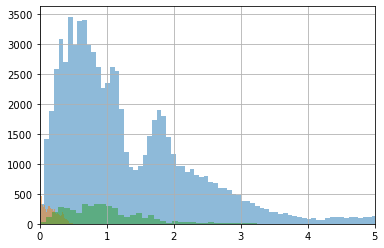

In [75]:
for c in y['Source'].unique():
    X[y['Source']==c].Z_BEST.hist(bins=100, alpha=0.5)
plt.xlim(0,5)

In [76]:
z = 0
#z = 3
delta_z = 0.5

redshift_filt = (X.Z_BEST >z) & (X.Z_BEST <(z+delta_z))
X_sliced = X[redshift_filt]

## Filling nan's

In [77]:
# fill nans with 0s
#X_filled = X.fillna(0)

# FIlling with mean, filling with 0s caused a weird split into 2 groups
#imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
#X_filled = imp_mean.fit_transform(X)

imp = IterativeImputer(max_iter=100, min_value=0)
X_filled = imp.fit_transform(X_sliced)

## Scaling

In [78]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, MaxAbsScaler

scaler = StandardScaler()
X_final = scaler.fit_transform(X_filled)

In [79]:
X.columns

Index(['ch1_flux_corr', 'ch2_flux_corr', 'Z_BEST'], dtype='object')

In [80]:
X.isna().sum()

ch1_flux_corr    601
ch2_flux_corr    102
Z_BEST             0
dtype: int64

## Running UMAP

In [81]:
reducer = umap.UMAP(n_neighbors=50, min_dist=0.1)
embedding = reducer.fit_transform(X_final)

In [82]:
embedding.shape

(29986, 2)

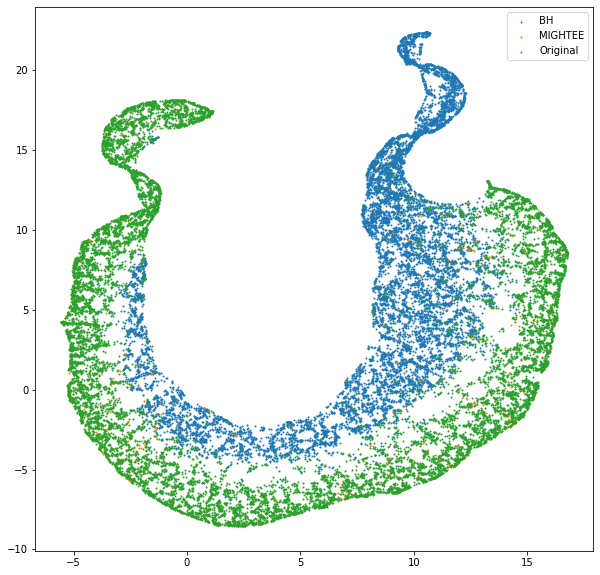

In [83]:
plt.figure(figsize=(10,10))

for i in np.unique(y['Source']):
    #filt = y.loc[sample.index]['Classification']==i
    filt = y['Source'][redshift_filt]==i
    plt.scatter(embedding[:,0][filt], embedding[:,1][filt], s=1,label=i)
plt.legend()
#plt.xlim(xmax=5)
plt.show()

In [286]:
tempdata = np.hstack((X_filled, embedding, y['Source'][redshift_filt].to_numpy()[:, np.newaxis] 
                      ,y['Classification'][redshift_filt].to_numpy()[:, np.newaxis]))
columns = list(X.columns)
columns.extend(['x', 'y', 'Source', 'class'])

temp = pd.DataFrame(data=tempdata, columns=columns)
temp.to_csv('temp.csv', index=False)

# Running umap on one dataset and then testing it on others

In [296]:
X_temp = X_original[redshift_filt]

/var/lib/condor/execute/dir_231614/ipykernel_248641/1845883398.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_temp = X_original[redshift_filt]


In [297]:
imp = IterativeImputer(max_iter=100, min_value=0)
X_temp = imp.fit_transform(X_temp)

In [298]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, MaxAbsScaler

scaler = StandardScaler()
X_temp = scaler.fit_transform(X_temp)

In [299]:
reducer = umap.UMAP(n_neighbors=50, min_dist=0.1)
embedding = reducer.fit_transform(X_final[y[redshift_filt]['Source']=='Original'])

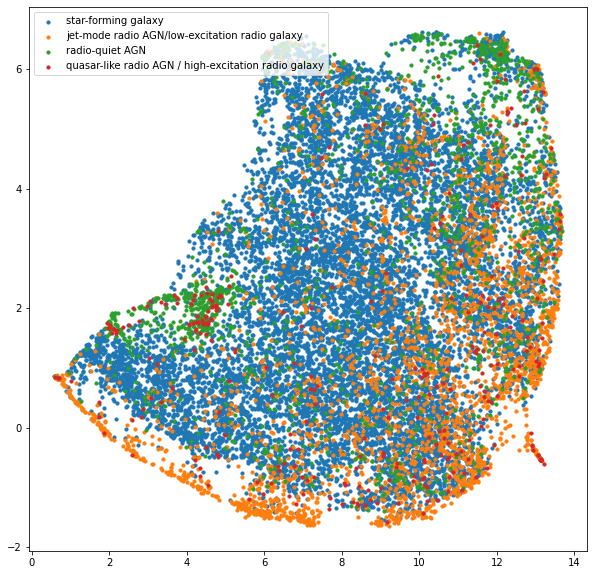

In [302]:
plt.figure(figsize=(10,10))
classes = ['star-forming galaxy',
           'jet-mode radio AGN/low-excitation radio galaxy',
           'radio-quiet AGN',
           'quasar-like radio AGN / high-excitation radio galaxy',
       ]
for i in classes:
    #filt = y.loc[sample.index]['Classification']==i
    filt = y['Classification'][y['Source']=='Original'][redshift_filt]==i
    plt.scatter(embedding[:,0][filt], embedding[:,1][filt], s=10,label=i)
plt.legend()
#plt.xlim(xmax=5)
plt.show()

In [303]:
embedding_MIGHTEE = reducer.transform(X_final[y[redshift_filt]['Source']=='MIGHTEE'])

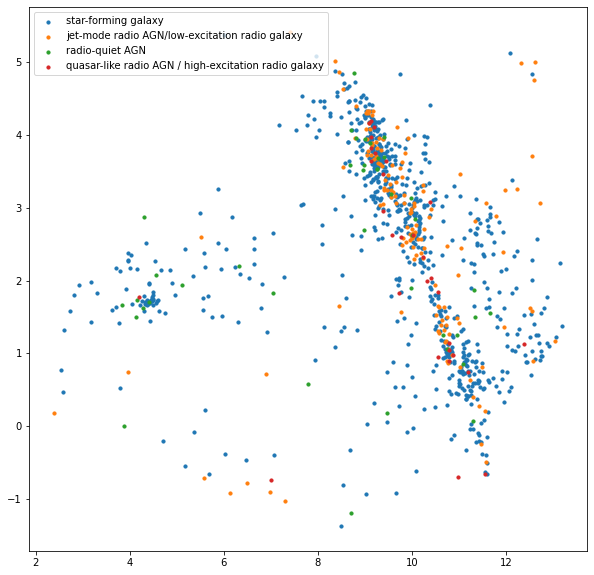

In [304]:
plt.figure(figsize=(10,10))
classes = ['star-forming galaxy',
           'jet-mode radio AGN/low-excitation radio galaxy',
           'radio-quiet AGN',
           'quasar-like radio AGN / high-excitation radio galaxy',
       ]
for i in classes:
    #filt = y.loc[sample.index]['Classification']==i
    filt = y['Classification'][y['Source']=='MIGHTEE'][redshift_filt]==i
    plt.scatter(embedding_MIGHTEE[:,0][filt], embedding_MIGHTEE[:,1][filt], s=10,label=i)
plt.legend()
#plt.xlim(xmax=5)
plt.show()

In [305]:
embedding_BH = reducer.transform(X_final[y[redshift_filt]['Source']=='BH'])

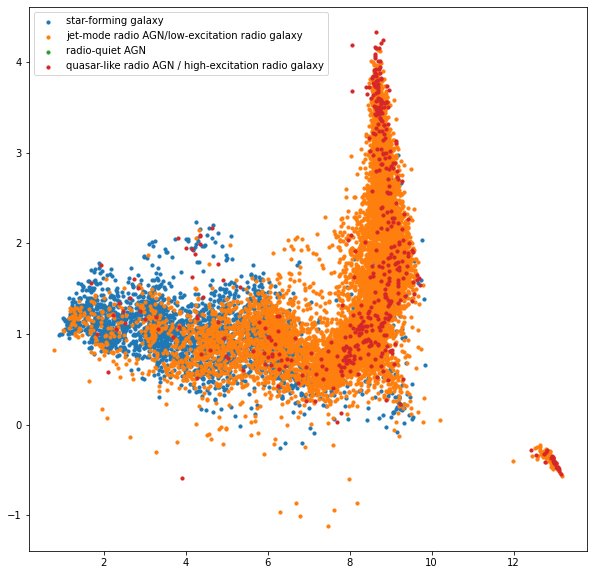

In [306]:
plt.figure(figsize=(10,10))
classes = ['star-forming galaxy',
           'jet-mode radio AGN/low-excitation radio galaxy',
           'radio-quiet AGN',
           'quasar-like radio AGN / high-excitation radio galaxy',
       ]
for i in classes:
    #filt = y.loc[sample.index]['Classification']==i
    filt = y['Classification'][y['Source']=='BH'][redshift_filt]==i
    plt.scatter(embedding_BH[:,0][filt], embedding_BH[:,1][filt], s=10,label=i)
plt.legend()
#plt.xlim(xmax=5)
plt.show()